# Multi-modal eval: GPT-4 w/ multi-modal embeddings and multi-vector retriever

`Multi-modal slide decks` is a public dataset that contains a dataset of question-answer pairs from slide decks with visual content.

The question-answer pairs are derived from the visual content in the decks, testing the ability of RAG to perform visual reasoning.

We evaluate this dataset using two approaches: 

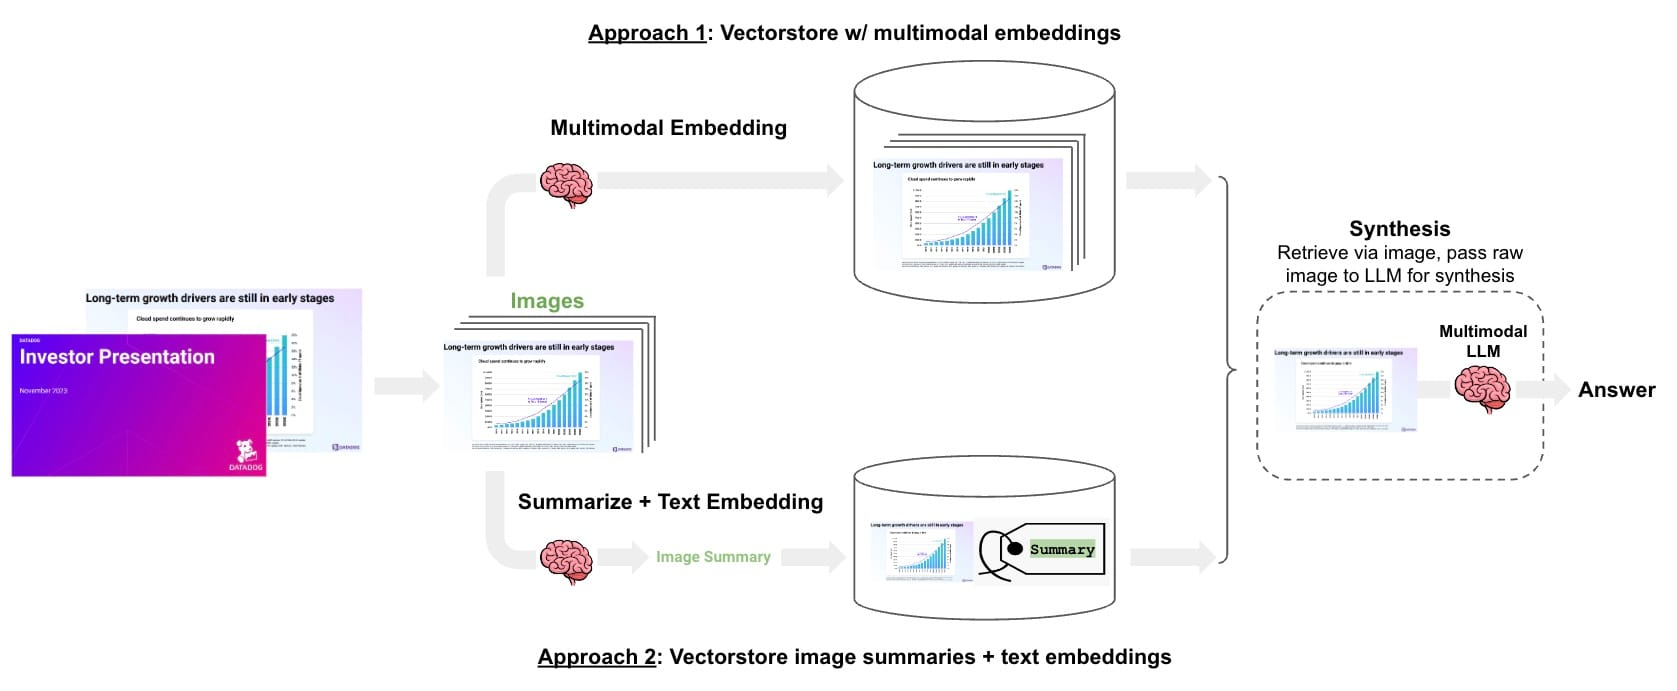

## Pre-requisites

In [ ]:
# %pip install -U langchain langsmith langchain_benchmarks
# %%pip install -U openai chromadb pypdfium2 open-clip-torch pillow

In [ ]:
import getpass
import os

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
env_vars = ["LANGCHAIN_API_KEY", "OPENAI_API_KEY"]
for var in env_vars:
    if var not in os.environ:
        os.environ[var] = getpass.getpass(prompt=f"Enter your {var}: ")

## Dataset

We can browse the available LangChain benchmark datasets for retrieval.

In [ ]:
from langchain_benchmarks import clone_public_dataset, registry

registry = registry.filter(Type="RetrievalTask")
registry

`Multi-modal slide decks` is the relevant dataset for our task.

In [ ]:
task = registry["Multi-modal slide decks"]
task

Clone the dataset so that it's available in our LangSmith datasets.

In [ ]:
clone_public_dataset(task.dataset_id, dataset_name=task.name)

Fetch the associated PDFs from remote cache for the dataset so that we can perform ingestion.

In [ ]:
from langchain_benchmarks.rag.tasks.multi_modal_slide_decks import get_file_names

file_names = list(get_file_names())  # PosixPath

## Load

For each presentation, extract an image for each slide.

In [ ]:
import os
import pypdfium2 as pdfium
from pathlib import Path


def get_images(file):
    """
    Get PIL images from PDF pages and save them to a specified directory
    :param file: Path to file
    :return: A list of PIL images
    """

    # Get presentation
    pdf = pdfium.PdfDocument(file)
    n_pages = len(pdf)

    # Extracting file name and creating the directory for images
    file_name = Path(file).stem  # Gets the file name without extension
    img_dir = os.path.join(Path(file).parent, "img")
    os.makedirs(img_dir, exist_ok=True)

    # Get images
    pil_images = []
    print(f"Extracting {n_pages} images for {file.name}")
    for page_number in range(n_pages):
        page = pdf.get_page(page_number)
        bitmap = page.render(scale=1, rotation=0, crop=(0, 0, 0, 0))
        pil_image = bitmap.to_pil()
        pil_images.append(pil_image)

        # Saving the image with the specified naming convention
        image_path = os.path.join(img_dir, f"{file_name}_image_{page_number + 1}.jpg")
        pil_image.save(image_path, format="JPEG")

    return pil_images


images = []
for fi in file_names:
    images.extend(get_images(fi))

Now, we convert each PIL image to a Base64 encoded string and set the image size.

Base64 encoded string can be input to GPT-4V.

In [ ]:
import io
import base64
from PIL import Image
from io import BytesIO


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string

    :param base64_string: Base64 string
    :param size: Image size
    :return: Re-sized Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    img_str = resize_base64_image(img_str, size=(960, 540))
    return img_str


images_base_64 = [convert_to_base64(i) for i in images]

If desired, we can plot the images to confirm that they were extracted correctly.

In [ ]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


i = 10
plt_img_base64(images_base_64[i])

## Index

We will test two approaches.

### Option 1: Vectorstore with multimodal embeddings

Here we will use [OpenCLIP multimodal embeddings](https://github.com/mlfoundations/open_clip).

There are [many to choose from](https://github.com/mlfoundations/open_clip/blob/main/docs/openclip_results.csv).

By default, it will use `model_name="ViT-H-14", checkpoint="laion2b_s32b_b79k"`.

This model favorably balances memory and performance.

However, you can test different models by passing them to OpenCLIPEmbeddings as `model_name=, checkpoint=`.

In [ ]:
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Make vectorstore
vectorstore_mmembd = Chroma(
    collection_name="multi-modal-rag",
    embedding_function=OpenCLIPEmbeddings(),
)

# Read images we extracted above
img_dir = os.path.join(Path(file_names[0]).parent, "img")
image_uris = sorted(
    [
        os.path.join(img_dir, image_name)
        for image_name in os.listdir(img_dir)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore_mmembd.add_images(uris=image_uris)

# Make retriever
retriever_mmembd = vectorstore_mmembd.as_retriever()

### Option 2: Multi-vector retriever

This approach will generate and index image summaries. See detail [here](https://blog.langchain.dev/semi-structured-multi-modal-rag/).

It will then retrieve the raw image to pass to GPT-4V for final synthesis.

The idea is that retrieval on image summaries:

* Does not rely on multi-modal embeddings
* Can perform better at retrieval of visually / semantically similar, but quantitatively different slide content

Note: there OpenAI's GPT-4V API can experince [non-deterministic](https://community.openai.com/t/400-errors-on-gpt-vision-api-since-today/534538/16) `BadRequestError`, which we handle. Hopefully this is resolved soon.

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage


def image_summarize(img_base64, prompt):
    """
    Make image summary

    :param img_base64: Base64 encoded string for image
    :param prompt: Text prompt for summarizatiomn
    :return: Image summarization prompt

    """
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(img_base64_list):
    """
    Generate summaries for images

    :param img_base64_list: Base64 encoded images
    :return: List of image summaries and processed images
    """

    # Store image summaries
    image_summaries = []
    processed_images = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply summarization to images
    for i, base64_image in enumerate(img_base64_list):
        try:
            image_summaries.append(image_summarize(base64_image, prompt))
            processed_images.append(base64_image)
        except:
            print(f"BadRequestError with image {i+1}")

    return image_summaries, processed_images


# Image summaries
image_summaries, images_base_64_processed = generate_img_summaries(images_base_64)

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary): 

* Store the raw images in the `docstore`.
* Store the image summaries in the `vectorstore` for semantic retrieval.

In [ ]:
import uuid
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.output_parser import StrOutputParser
from langchain.storage import InMemoryStore


def create_multi_vector_retriever(vectorstore, image_summaries, images):
    """
    Create retriever that indexes summaries, but returns raw images or texts

    :param vectorstore: Vectorstore to store embedded image sumamries
    :param image_summaries: Image summaries
    :param images: Base64 encoded images
    :return: Retriever
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore_mvr = Chroma(
    collection_name="multi-modal-rag-mv", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore_mvr,
    image_summaries,
    images_base_64_processed,
)

## RAG

Create a pipeline for retrieval of relevant images based on semantic similarity to the input question.

Pass the images to GPT-4V for answer synthesis.

In [ ]:
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough


def prepare_images(docs):
    """
    Prepare iamges for prompt

    :param docs: A list of base64-encoded images from retriever.
    :return: Dict containing a list of base64-encoded strings.
    """
    b64_images = []
    for doc in docs:
        if isinstance(doc, Document):
            doc = doc.page_content
        b64_images.append(doc)
    return {"images": b64_images}


def img_prompt_func(data_dict, num_images=2):
    """
    GPT-4V prompt for image analysis.

    :param data_dict: A dict with images and a user-provided question.
    :param num_images: Number of images to include in the prompt.
    :return: A list containing message objects for each image and the text prompt.
    """
    messages = []
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"][:num_images]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    text_message = {
        "type": "text",
        "text": (
            "You are an analyst tasked with answering questions about visual content.\n"
            "You will be give a set of image(s) from a slide deck / presentation.\n"
            "Use this information to answer the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(prepare_images),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)
chain_multimodal_rag_mmembd = multi_modal_rag_chain(retriever_mmembd)

## Eval

Run evaluation on our dataset:

* `task.name` is the dataset of QA pairs that we cloned
* `eval_config` specifies the [LangSmith evaluator](https://docs.smith.langchain.com/evaluation/evaluator-implementations#correctness-qa-evaluation) for our dataset, which will use GPT-4 as a grader
* The grader will evaluate the chain-generated answer to each question relative to ground truth

In [ ]:
import uuid

from langchain.smith import RunEvalConfig
from langsmith.client import Client

# Evaluator configuration
client = Client()
eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

# Experiments
chain_map = {
    "multi_modal_mvretriever_gpt4v": chain_multimodal_rag,
    "multi_modal_mmembd_gpt4v": chain_multimodal_rag_mmembd,
}

# Run evaluation
run_id = uuid.uuid4().hex[:4]
test_runs = {}
for project_name, chain in chain_map.items():
    test_runs[project_name] = client.run_on_dataset(
        dataset_name=task.name,
        llm_or_chain_factory=lambda: (lambda x: x["Question"]) | chain,
        evaluation=eval_config,
        verbose=True,
        project_name=f"{project_name}-{run_id}",
        project_metadata={"chain": project_name},
    )